In [1]:
### Xi -> reference representation  Xj -> target representation
## adjust reference Xi  to  Xi' => CKA(Xi', Xj) ----> 1
# R -> min ||XjR - Xi'||

##### adjust : keep similar samples and highlight the diff samples' difference 
# step1: find diff samples and same samples
# step2: adjust diff samples or just keep the same set

In [1]:
#### 

import torch
import sys
sys.path.append("..")
from singleVis.data import NormalDataProvider
REF_PATH = "/home/yifan/dataset/clean/pairflip/cifar10/0"

CLEAN_PATH = "/home/yifan/dataset/clean_ref/pairflip/cifar10/0"
sys.path.append(REF_PATH)


from config import config

SETTING = config["SETTING"]
CLASSES = config["CLASSES"]
DATASET = config["DATASET"]
GPU_ID = config["GPU"]
EPOCH_START = config["EPOCH_START"]
EPOCH_END = config["EPOCH_END"]
EPOCH_PERIOD = config["EPOCH_PERIOD"]

# Training parameter (subject model)
TRAINING_PARAMETER = config["TRAINING"]
NET = TRAINING_PARAMETER["NET"]
LEN = TRAINING_PARAMETER["train_num"]

# Training parameter (visualization model)
VISUALIZATION_PARAMETER = config["VISUALIZATION"]
PREPROCESS = VISUALIZATION_PARAMETER["PREPROCESS"]
LAMBDA = VISUALIZATION_PARAMETER["LAMBDA"]
B_N_EPOCHS = VISUALIZATION_PARAMETER["BOUNDARY"]["B_N_EPOCHS"]
L_BOUND = VISUALIZATION_PARAMETER["BOUNDARY"]["L_BOUND"]
INIT_NUM = VISUALIZATION_PARAMETER["INIT_NUM"]
ALPHA = VISUALIZATION_PARAMETER["ALPHA"]
BETA = VISUALIZATION_PARAMETER["BETA"]
MAX_HAUSDORFF = VISUALIZATION_PARAMETER["MAX_HAUSDORFF"]
# HIDDEN_LAYER = VISUALIZATION_PARAMETER["HIDDEN_LAYER"]
ENCODER_DIMS = VISUALIZATION_PARAMETER["ENCODER_DIMS"]
DECODER_DIMS = VISUALIZATION_PARAMETER["DECODER_DIMS"]
S_N_EPOCHS = VISUALIZATION_PARAMETER["S_N_EPOCHS"]
T_N_EPOCHS = VISUALIZATION_PARAMETER["T_N_EPOCHS"]
N_NEIGHBORS = VISUALIZATION_PARAMETER["N_NEIGHBORS"]
PATIENT = VISUALIZATION_PARAMETER["PATIENT"]
MAX_EPOCH = VISUALIZATION_PARAMETER["MAX_EPOCH"]

VIS_MODEL_NAME = 'vis'
EVALUATION_NAME = VISUALIZATION_PARAMETER["EVALUATION_NAME"]

SEGMENTS = [(EPOCH_START, EPOCH_END)]
# define hyperparameters
DEVICE = torch.device("cuda:{}".format(GPU_ID) if torch.cuda.is_available() else "cpu")

import Model.model as subject_model
net = eval("subject_model.{}()".format(NET))


ref_provider = NormalDataProvider(REF_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
tar_provider = NormalDataProvider(CLEAN_PATH, net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
ref_train_data = ref_provider.train_representation(200).squeeze()
tar_train_data = tar_provider.train_representation(200).squeeze()
ref_prediction = ref_provider.get_pred(200, ref_train_data)
tar_prediction = tar_provider.get_pred(200, tar_train_data)
ref_prediction_res = ref_prediction.argmax(axis=1)
tar_prediction_res = tar_prediction.argmax(axis=1)
### get confidence scores result
from scipy.special import softmax
import numpy as np
def get_conf(pred):
    scores = np.amax(softmax(pred, axis=1), axis=1)
    return scores
ref_scores = get_conf(ref_prediction)
tar_scores =  get_conf(tar_prediction)


/home/yifan/miniconda3/envs/deepdebugger/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Finish initialization...
Finish initialization...


100%|██████████| 250/250 [00:00<00:00, 9463.60it/s]


In [2]:
import math
distance_high_indicates = []
same_set_indicates = []
def EMAE(Y, y, a=1.5):
    """
    param：
        Y: 原始序列（假定波动较大）
        y: 拟合序列（假定波动较小）
        a: 指数的自变量，≥1，该值越大，则两序列间的残差（特别是残差的离群值）对EMAE返回值影响的强化作用越明显；
        当a=1时，EMAE化简为MAE。
    return：
        指数MAE值，该值的大小与两条序列间平均偏差程度成正比，该值越大，平均偏差程度越大；
        且两序列间的残差（特别是残差的离群值）对EMAE的影响比MAE大。
    """

    Y, y = np.array(Y), np.array(y)
    Y[Y < 0] = 0  # 使指数的底数≥1，则所有指数均为递增函数
    y[y < 0] = 0
    emae = sum(abs((Y+1)**a - (y+1)**a)) / len(Y)

    return emae

for i in range(len(ref_prediction)):
    mes_val = EMAE(ref_prediction[i], tar_prediction[i])
    if mes_val > 25:
        distance_high_indicates.append(i)
    elif mes_val < 0.1:
        same_set_indicates.append(i)
#### 
diff_indicates = []
same_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1 and  (i in same_set_indicates):     
        same_indicates.append(i)
    else:
        diff_indicates.append(i)

# need_adjust_indicates = []
# for i in range(len(ref_prediction)):
#     if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates):     
#         same_indicates.append(i)
#     else:
#         diff_indicates.append(i)


In [3]:
same_indicates

[1256, 10623, 21614, 35621]

In [19]:
import os
import sys
sys.path.append("..")
from CKA_utils.CKA import CKA, CudaCKA
np_cka = CKA()
X = ref_train_data[[0,1,2]]
Y = tar_train_data[[0,1,2]]

print('Linear CKA, between X and Y: {}'.format(np_cka.linear_CKA(X, Y)))
# print('RBF Kernel CKA, between X and Y: {}'.format(np_cka.kernel_CKA(X, Y)))


Linear CKA, between X and Y: 0.9957678080589172


In [18]:
#### same_set representation CKA
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs target epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs target epoch 200
0.9999999999999952


In [57]:
# adjust X diff
app_ref_arr = [30,4,6,9,10,28,19,7,8,2]
ref_train_data = ref_provider.train_representation(200).squeeze()
import math
res_same_indicates = []
res_diff_indicates = []
for i in range(len(ref_prediction)):
    # if tar_prediction_res[i] == ref_prediction_res[i] and ref_scores[i] == tar_scores[i] and  (i in same_set_indicates): 
    if tar_prediction_res[i] == ref_prediction_res[i] and math.fabs(ref_scores[i] - tar_scores[i]) < 0.1:     
        res_same_indicates.append(i)
    else:
        res_diff_indicates.append(i)

for i in range(len(res_diff_indicates)):
    index = res_diff_indicates[i]
    pred_res = tar_prediction_res[index]
    pred_score = tar_scores[index]
    filter_set = []
    for j in range(len(ref_prediction_res)):
        if pred_res == ref_prediction_res[j] and ref_scores[j] == pred_score:
            filter_set.append(j)
    if len(filter_set) > 0:
        print('ifififif',len(filter_set), index,new_index)
        ref_train_data[index] = ref_train_data[filter_set[0]]
    else:
        
        new_index = app_ref_arr[pred_res]
        print('len(filter_set)',len(filter_set), index,new_index)
        ref_train_data[index] = ref_train_data[new_index]



len(filter_set) 0 0 7
len(filter_set) 0 2 7
len(filter_set) 0 3 7
len(filter_set) 0 8 4
len(filter_set) 0 9 30
len(filter_set) 0 10 6
len(filter_set) 0 11 7
len(filter_set) 0 13 4
len(filter_set) 0 14 4
len(filter_set) 0 16 7
len(filter_set) 0 17 6
len(filter_set) 0 19 2
len(filter_set) 0 20 7
ifififif 216 21 7
ifififif 2 22 7
len(filter_set) 0 23 6
len(filter_set) 0 24 4
len(filter_set) 0 25 2
len(filter_set) 0 27 6
len(filter_set) 0 28 2
ifififif 12 29 2
len(filter_set) 0 30 28
len(filter_set) 0 31 6
ifififif 342 34 6
ifififif 22 35 6
len(filter_set) 0 36 6
len(filter_set) 0 38 7
len(filter_set) 0 39 9
len(filter_set) 0 40 6
len(filter_set) 0 41 6
len(filter_set) 0 42 30
len(filter_set) 0 43 7
len(filter_set) 0 47 30
len(filter_set) 0 48 7
len(filter_set) 0 49 7
len(filter_set) 0 50 6
len(filter_set) 0 51 4
len(filter_set) 0 52 2
len(filter_set) 0 53 30
len(filter_set) 0 55 7
len(filter_set) 0 56 6
len(filter_set) 0 57 2
len(filter_set) 0 58 7
ifififif 2 59 7
len(filter_set) 0 61 2
l

In [31]:
len(res_diff_indicates)

37775

In [20]:
#### same_set representation CKA
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs target epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs target epoch 200
0.9973595189490225


In [21]:
len(same_indicates)

1177

In [7]:
ref_provider.training_accu(200)

100%|██████████| 250/250 [00:00<00:00, 4693.23it/s]


0.99986

In [14]:
tar_provider.training_accu(100)

100%|██████████| 250/250 [00:00<00:00, 9523.07it/s]


0.333

In [58]:

# Step2: Computing the loss 
def compute_loss(X, Y, R):
    '''
    Inputs: 
       X: a matrix of dimension (m,n) where the columns are the English embeddings.
       Y: a matrix of dimension (m,n) where the columns correspong to the French embeddings.
       R: a matrix of dimension (n,n) - transformation matrix from English to French vector space embeddings.
    Outputs:
       L: a matrix of dimension (m,n) - the value of the loss function for given X, Y and R.
    '''
    ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
    # m is the number of rows in X
    m = len(X)

    # diff is XR - Y
    diff = np.dot(X, R) - Y

    # diff_squared is the element-wise square of the difference
    diff_squared = diff**2

    # sum_diff_squared is the sum of the squared elements
    sum_diff_squared = diff_squared.sum()

    # loss is the sum_diff_squared divided by the number of examples (m)
    loss = sum_diff_squared/m
    ### END CODE HERE ###
    return loss
def compute_gradient(X, Y, R):
    '''
        the gradient of the loss with respect to the matrix encodes how much a tiny change 
    in some coordinate of that matrix affect the change of loss function.
        Gradient descent uses that information to iteratively change matrix R until we reach 
    a point where the loss is minimized.
    Inputs: 
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        R: a matrix of dimension (n,n) - transformation matrix from Y2d to X2d
    Outputs:
       g: a matrix of dimension (n,n) - gradient of the loss function L for given X, Y and R.
    '''
    # m is the number of rows in X
    m = len(X)

    rows, columns = X.shape

    gradient = (np.dot(X.T, np.dot(X, R) - Y) * 2)/rows
    assert gradient.shape == (columns, columns)
    ### END CODE HERE ###
    return gradient


# Most of the time we iterate for a fixed number of training steps rather than iterating until the loss falls below a threshold.

# 1.Calculate gradient g of the loss with respect to the matrix R. 
# 2. Update R (Rnew = Rold - αg) . α is the learning rate which is a scalar.

# alignment_embeddings
def align_embeddings(X: np.ndarray, Y: np.ndarray,
                      train_steps:int,
                      learning_rate: float=0.0003,
                      seed: int=129) -> np.ndarray:
    '''
    Finding the optimal R with gradient descent algorithm
    Inputs:
        X: a matrix of dimension (m,n) where the colums are the contrast representation 
        Y: a matrix of dimension (m,n) where the colums are the reference representation
        learning_rate: positive float - describes how big steps will  gradient descent algorithm do.
    Outputs:
        R: a matrix of dimension (n,n) - the projection matrix that minimizes the F norm ||projector(X R) - projector ( Y )||^2
    '''
    # the number of columns in X is the number of dimensions for a word vector (e.g. 300)
    # R is a square matrix with length equal to the number of dimensions in th  word embedding
    R = np.random.rand(X.shape[1], X.shape[1])
    # R = Variable(torch.ones(X.shape[1],X.shape[1]),requires_grad=True)

   

        
    # train_steps = 100000
    for i in range(train_steps):
        if i%500 == 0:
            loss = compute_loss(X,Y,R)
            print(f"iteration {i}, loss {loss}") 



        ### START CODE HERE (REPLACE INSTANCES OF 'None' with your code) ###
        # use the function that you defined to compute the gradient
        gradient = compute_gradient(X, Y, R)
       
        
         # update R by subtracting the learning rate times gradient
        R -= learning_rate * gradient
        ### END CODE HERE ###
    
    return R




In [60]:
len(same_indicates)

7202

In [ ]:
indiactes = same_indicates.extend(res_diff_indicates)

In [59]:
Y = ref_train_data[same_indicates]
X = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
S = align_embeddings(X, Y, 15000)

iteration 0, loss 23471877.641108375
iteration 500, loss 4719.98646409175


KeyboardInterrupt: 

In [22]:
X = ref_train_data[same_indicates]
Y = tar_train_data[same_indicates]

# X_pred = exchange_provider.get_pred(200, ref_provider.train_representation(200))
# Y_pred = ref_provider.get_pred(200, ref_provider.train_representation(200))
R = align_embeddings(X, Y, 15000)

NameError: name 'align_embeddings' is not defined

In [11]:
import os
import numpy as np
import json
clean_path = os.path.join(REF_PATH, 'clean_label.json')
with open(clean_path, "r") as f:
    clean_labels = np.array(json.load(f))

selected_indicates = []

pairs = []
for i in range(len(clean_labels)):
    if clean_labels[i] == 3:
        selected_indicates.append(i)
       

In [13]:
same = []
diff = []
for i in range(len(ref_prediction)):
    if tar_prediction_res[i] == ref_prediction_res[i]:     
        same.append(i)
    else:
        diff.append(i)

In [59]:
sample_Ref = []
for i in range(len(ref_prediction_res)):
    if ref_prediction_res[i] == 3 and ref_scores[i] - 0.9954508 < 0.0001:
        sample_Ref.append(i)


In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path="/home/yifan/dataset/changeModelLayer/pairflip/cifar10/0", vis_model_name=VIS_MODEL_NAME, device="cpu")
provider = NormalDataProvider("/home/yifan/dataset/changeModelLayer/pairflip/cifar10/0" ,net, EPOCH_START, EPOCH_END, EPOCH_PERIOD, split=-1, device=DEVICE, classes=CLASSES,verbose=1)
I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(provider, I,I, np.dot(provider.train_representation(100),I), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [ ]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(tar_provider, R,I, np.dot(tar_provider.train_representation(200),S), projector, 200,[],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [81]:
after_prediction = tar_provider.get_pred(200, np.dot(ref_train_data,R))

100%|██████████| 250/250 [00:00<00:00, 9109.97it/s]


In [92]:
after_prediction_res = after_prediction.argmax(axis=1)
print(after_prediction_res[[5645, 12673, 14647]],tar_prediction_res[[5645, 12673, 14647]])


[5 5 3] [5 5 3]


In [49]:
after_ref = ref_provider.get_pred(200,np.dot(tar_train_data,S) )

100%|██████████| 250/250 [00:00<00:00, 9390.63it/s]


In [50]:
after_ref.argmax(axis=1)

array([6, 9, 9, ..., 9, 1, 1])

In [40]:
tar_prediction_res

array([6, 9, 9, ..., 9, 1, 1])

In [41]:
ref_prediction_res

array([6, 9, 9, ..., 9, 1, 1])

In [82]:
after_prediction_res

NameError: name 'after_prediction_res' is not defined

In [51]:
after_diff = []
after_prediction_res = after_ref.argmax(axis=1)
for i in range(len(after_prediction)):
   
    if after_prediction_res[i] != tar_prediction_res[i]:
        after_diff.append(i)


In [52]:
len(after_diff)

975

Computing decision regions ...


100%|██████████| 1/1 [00:00<00:00, 5511.57it/s]


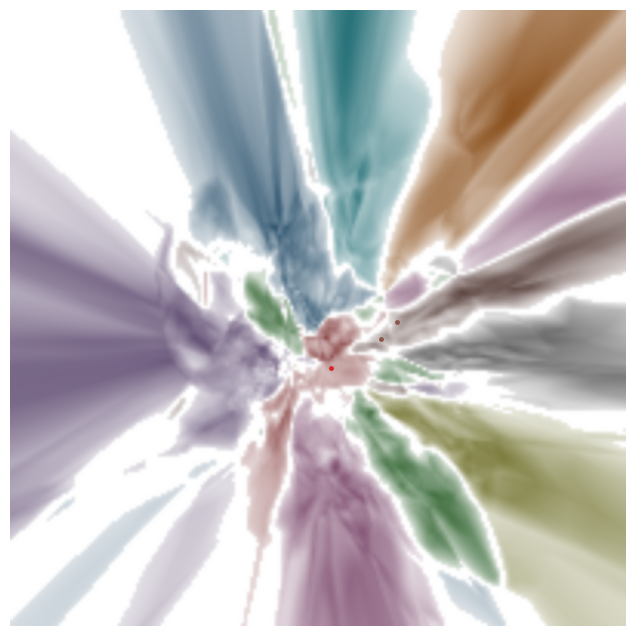

In [80]:
import json
import os
from singleVis.SingleVisualizationModel import VisModel
from singleVis.projector import TimeVisProjector
model = VisModel(ENCODER_DIMS, DECODER_DIMS)
projector = TimeVisProjector(vis_model=model, content_path=REF_PATH, vis_model_name=VIS_MODEL_NAME, device="cpu")

I = np.eye(512)
from representationTrans.trans_visualizer_border import visualizer
# from representationTrans.visualizer import visualizer
vis = visualizer(ref_provider, I,I, np.dot(ref_provider.train_representation(200),I), projector, 200,[11077,18799,1496],'tab10')
save_dir = os.path.join('/home/yifan/projects' , "imgcontrast")
# os.makedirs(save_dir)

vis.savefig(200, path=os.path.join(save_dir, "origin_contrast"))

In [65]:
for i in range(len(diff_indicates)):
    tar_prediction_res[0]


In [72]:
len(same_indicates)

5

In [91]:
import numpy as np
from sklearn.cross_decomposition import CCA
# 建立模型
X = ref_train_data
Y = tar_train_data
cca = CCA(n_components=1)
# 训练数据
cca.fit(X, Y)
# print(X)
X_train_r, Y_train_r = cca.transform(X, Y)
# print(X_train_r)
print('referece epoch 200 vs current epoch 200')
print(np.corrcoef(X_train_r[:, 0], Y_train_r[:, 0])[0, 1]) #输出相关系数

referece epoch 200 vs current epoch 200
0.9764722451592688
